In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from IPython.display import Image


In [4]:
import torch
import numpy as np
import os
import torch.nn as nn
from tqdm import tqdm
import json
from functools import partial
from torch import einsum, nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from einops import pack, rearrange, reduce, repeat, unpack


In [5]:
def findAllFile(base):
    file_path = []
    for root, ds, fs in os.walk(base, followlinks=True):
        for f in fs:
            fullname = os.path.join(root, f)
            file_path.append(fullname)
    return file_path



In [6]:
from configs.config import cfg, get_cfg_defaults
def load_vqvae(gen_cfg):

    body_cfg = get_cfg_defaults()
    body_cfg.merge_from_file(gen_cfg.vqvae.body_config)
    body_model = (
        instantiate_from_config(body_cfg.vqvae).to(device).eval()
    )
    body_model.load(os.path.join(body_cfg.output_dir, "vqvae_motion.pt"))

    if gen_cfg.vqvae.left_hand_config is  None and gen_cfg.vqvae.right_hand_config is None:
        return body_model, body_cfg
    
    if gen_cfg.vqvae.left_hand_config is not None:
        left_cfg = get_cfg_defaults()
        left_cfg.merge_from_file(gen_cfg.vqvae.left_hand_config)
        left_hand_model = instantiate_from_config(left_cfg.vqvae).to(device).eval()
        left_hand_model.load(
            os.path.join(left_cfg.output_dir, "vqvae_motion.pt")
        )
    else:
        left_hand_model = None
        
    if gen_cfg.vqvae.right_hand_config is not None:
        right_cfg = get_cfg_defaults()
        right_cfg.merge_from_file(gen_cfg.vqvae.right_hand_config)
        right_hand_model = instantiate_from_config(right_cfg.vqvae).to(device).eval()
        right_hand_model.load(
            os.path.join(right_cfg.output_dir, "vqvae_motion.pt")
        )
    else:
        right_hand_model = None

    return body_model, left_hand_model , right_hand_model , body_cfg , left_cfg , right_cfg


In [7]:
def bkn_to_motion(codes, dset):
        # codes b k n
        
        k = codes.shape[1]
        body_inds = codes[:, 0]
        body_motion = body_model.decode(body_inds[0:1]).detach().cpu()
        

        if "g" in dataset_args.hml_rep:
            z = torch.zeros(
                body_motion.shape[:-1] + (2,),
                dtype=body_motion.dtype,
                device=body_motion.device,
            )
            body_motion = torch.cat(
                [body_motion[..., 0:1], z, body_motion[..., 1:]], -1
            )

        body_M = dset.toMotion(
            body_motion[0],
            motion_rep=MotionRep("body"),
            hml_rep=body_cfg.dataset.hml_rep,
        )
        
        
        if k == 3:
            left_inds = codes[:, 1]
            right_inds = codes[:, 2]
            
            left_motion = left_hand_model.decode(left_inds[0:1]).detach().cpu()
            right_motion = right_hand_model.decode(right_inds[0:1]).detach().cpu()
        
            left_M = dset.toMotion(
                left_motion[0],
                motion_rep=MotionRep("left_hand"),
                hml_rep=left_cfg.dataset.hml_rep,
            )
            right_M = dset.toMotion(
                right_motion[0],
                motion_rep=MotionRep("right_hand"),
                hml_rep=right_cfg.dataset.hml_rep,
            )
            full_M = dset.to_full_joint_representation(body_M, left_M, right_M)
            return full_M

        return body_M

# Muse

In [8]:
from core import MotionTokenizerParams, pattern_providers

from core.param_dataclasses import pattern_providers
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
from core.models.utils import instantiate_from_config, get_obj_from_str
from core import MotionRep, AudioRep, TextRep
from core.datasets.conditioner import ConditionProvider,ConditionFuser
from core.models.generation.muse import MLMModel, MotionMuse
import einops
from configs.config_t2m import get_cfg_defaults as muse_get_cfg_defaults
from core import MotionTokenizerParams

from core.models.generation.translation_transformer import TranslationTransformer
from core.datasets.text_encoders import BERTConditioner, ClipConditioner, T5Conditioner, parse_prompt_attention
from core.datasets.audio_encoders import EncodecConditioner, LibrosaConditioner

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
gen_cfg = muse_get_cfg_defaults()
gen_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse_critic/motion_muse_critic.yaml")
gen_cfg.freeze()

In [22]:
tranformer_config = gen_cfg.motion_generator
fuse_config = gen_cfg.fuser
pattern_config = gen_cfg.codebooks_pattern
dataset_args = gen_cfg.dataset

target = tranformer_config.pop("target")


In [23]:
motion_gen = MotionMuse(tranformer_config , fuse_config , pattern_config).to(device)
# motion_gen = torch.compile(motion_gen)
pkg = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse_critic/motion_muse.pt", map_location="cuda")
motion_gen.load_state_dict(pkg["model"])

<All keys matched successfully>

In [12]:
pkg["steps"]

tensor([110000.], device='cuda:0')

In [197]:
# from core.models.generation.translation_transformer import TranslationTransformer
# from configs.config_t2m import get_cfg_defaults as trans_get_cfg_defaults

# t_cfg = trans_get_cfg_defaults()
# t_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_translation/motion_translation.yaml")
# # t_cfg.freeze()

# tranformer_config2 = t_cfg.translation_transformer
# fuse_config2 = t_cfg.fuser
# dataset_args2 = t_cfg.dataset

# target2 = tranformer_config2.pop("target")

# trans_former = TranslationTransformer(tranformer_config2, fuse_config2).to(device)
# trans_former.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_translation/translation_transformer.pt")

In [13]:
body_model, body_cfg = load_vqvae(gen_cfg)

Sync is turned on False
loaded model with  0.03015906736254692 tensor([110000.], device='cuda:0') steps


In [14]:
condition_provider = ConditionProvider(
            text_conditioner_name = dataset_args.text_conditioner_name,
            motion_rep=MotionRep(dataset_args.motion_rep),
            audio_rep=AudioRep(dataset_args.audio_rep),
            text_rep=TextRep(dataset_args.text_rep),
            motion_padding=dataset_args.motion_padding,
            audio_padding=dataset_args.audio_padding,
            motion_max_length_s=dataset_args.motion_max_length_s,
            audio_max_length_s=dataset_args.audio_max_length_s,
            pad_id = MotionTokenizerParams(tranformer_config.num_tokens).pad_token_id,
            fps=30/4,
            # device = "cpu"
        )

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [15]:
from core.datasets.base_dataset import BaseMotionDataset
base_dset = BaseMotionDataset(motion_rep=MotionRep.BODY , hml_rep= "gpvc")

In [16]:
beat = "/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/beat/1_wayne_0_1_1.wav"
choreo = "/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/choreomaster/0071.wav"
mbr = "/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/aist/mBR0.wav"
mj = "/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/aist/mJB0.wav"

In [20]:
_, conditions = condition_provider(raw_audio= beat, raw_text="a person speaks happily with exagerrated hand movements" )
_, neg_conditions = condition_provider(raw_text="body movement")
gen_ids = motion_gen.generate(conditions =conditions, neg_conditions = neg_conditions, duration_s = 4, temperature = 0.2 ,timesteps=18, cond_scale = 8)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 41.90it/s]


In [74]:
# _, neg_conditions2 = condition_provider2(raw_text="body movement")

In [47]:
_, conditions = condition_provider(raw_audio= beat, raw_text="a person gives a speech angrily with exagerrated hand movements" )
_, neg_conditions = condition_provider(raw_text="dancing")

In [75]:
_, conditions = condition_provider(raw_audio= None , raw_text = "a person does ballet with a lot of turns and movement")
_, neg_conditions = condition_provider(raw_text="jittery motion, slow, stop")

In [114]:
_, conditions = condition_provider(raw_audio= None, raw_text="a person jumps super high" )
_, neg_conditions = condition_provider(raw_text="dancing")

In [121]:

gen_ids = motion_gen.generate(conditions =conditions, neg_conditions = None, \
                              duration_s = 4, temperature = 1.0 ,timesteps=24, \
                              cond_scale = 8,force_not_use_token_critic = False)



torch.Size([1, 1, 30]) torch.Size([1, 1])


100%|███████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.86it/s]


In [119]:
gen_motion = bkn_to_motion(gen_ids, base_dset)
base_dset.render_hml(
                    gen_motion,
                    "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/gen_novel.gif",
                    zero_trans = True,
                    zero_orient = True,
    
                )

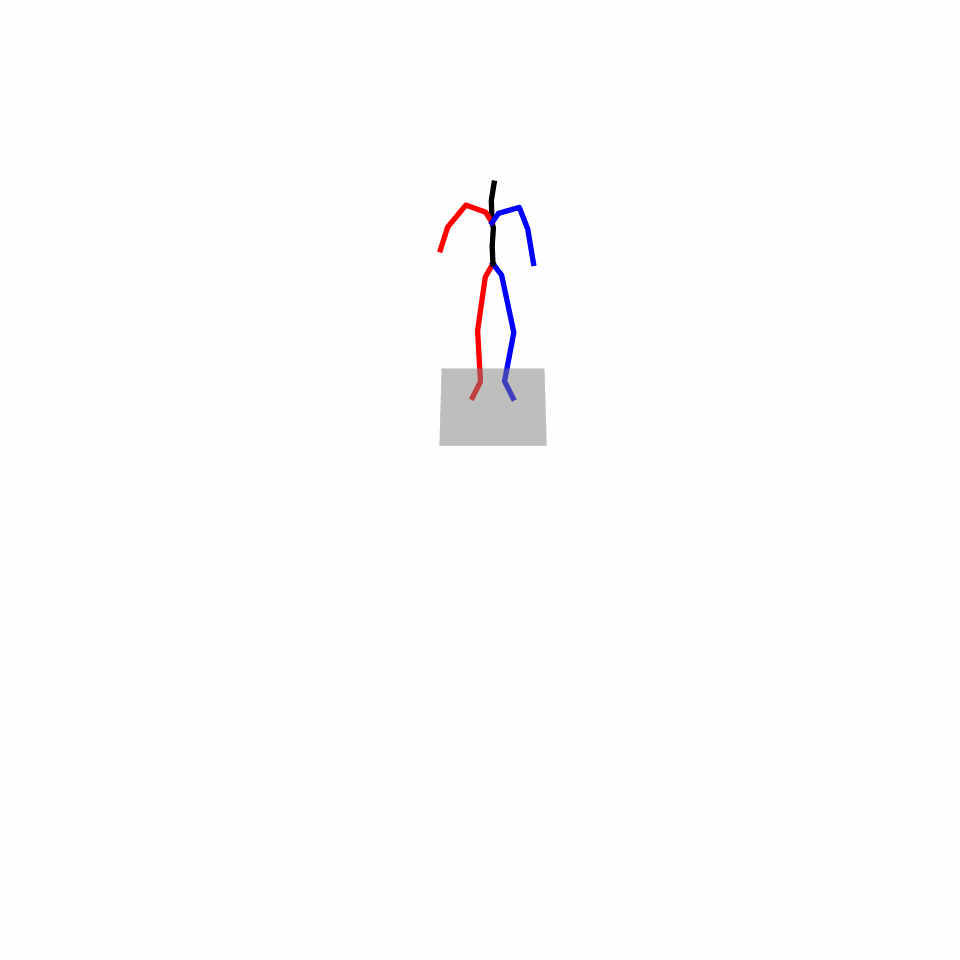

In [120]:
Image(open("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/gen_novel.gif",'rb').read())

In [6]:
from core.datasets.audio_encoders import EncodecConditioner

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
encodec_model = EncodecConditioner(target_sr = 9600)

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [85]:
# bts = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/audio/encodec/beat/")
# chrp = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/choreomaster/")
# aist = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/aist/")

In [8]:
bts = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/beat/")
chrp = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/choreomaster/")
aist = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/aist/")

In [30]:
# bts = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/beat/")
# for i in bts:
#     name =os.path.basename(i).split(".")[0]
#     enc_audio = encodec_model(i)
#     print(name , enc_audio.shape)
#     np.save(f"/srv/hays-lab/scratch/sanisetty3/motionx/audio/encodec/beat/{name}.npy" , np.array(enc_audio.cpu()) )
    

In [29]:
# chr = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/choreomaster/")
# for i in chr:
#     name =os.path.basename(i).split(".")[0]
#     enc_audio = encodec_model(i)
#     print(name , enc_audio.shape)
#     np.save(f"/srv/hays-lab/scratch/sanisetty3/motionx/audio/encodec/choreomaster/{name}.npy" , np.array(enc_audio.cpu()) )
    

In [28]:
# chr = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/aist/")
# for i in chr:
#     name =os.path.basename(i).split(".")[0]
#     enc_audio = encodec_model(i)
#     print(name , enc_audio.shape)
#     np.save(f"/srv/hays-lab/scratch/sanisetty3/motionx/audio/encodec/aist/{name}.npy" , np.array(enc_audio.cpu()) )
    

In [17]:
bts = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/audio/encodec/beat/")
chrp = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/audio/encodec/choreomaster/")
aist = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/audio/encodec/aist/")

In [18]:
btss = [np.load(p)[:120] for p in bts]
chr = [np.load(p)[:120] for p in chrp]
aists = [np.load(p)[:120] for p in aist]

In [19]:
np.unique(chr , axis = 0).shape

(36, 120, 128)

In [31]:
all = np.concatenate([np.array(btss) , np.array(chr) , np.array(aists)] , 0)

In [32]:
all = all.reshape(all.shape[0] , -1)

In [55]:
all.shape

(196, 15360)

In [33]:
y = np.array([1]*len(btss) + [0]*len(chr) + [2]*len(aists))

In [34]:
y.shape

(1724,)

In [35]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

In [36]:
X_embedded = TSNE(n_components=2, learning_rate='auto' , n_iter = 1000).fit_transform(all)


In [37]:
X_embedded.shape

(1724, 2)

<Axes: >

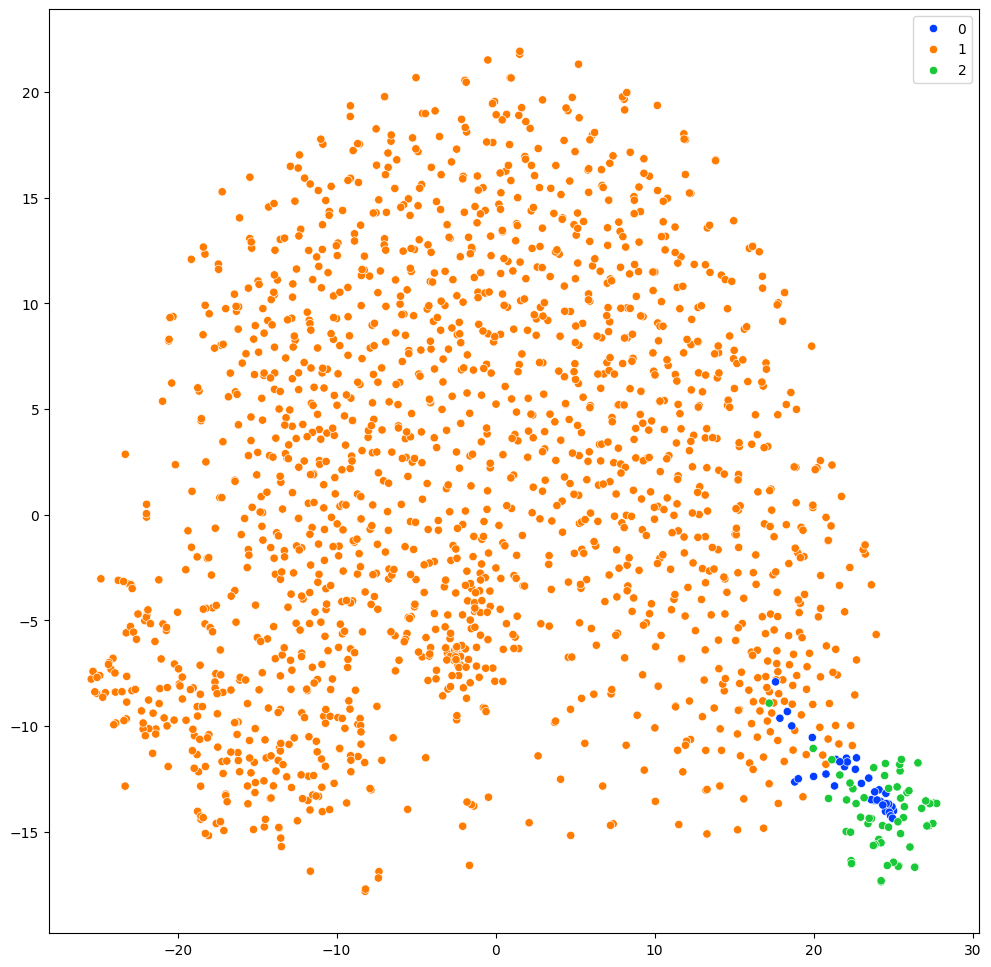

In [38]:
plt.figure(figsize = (12,12))
sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue = y, palette = "bright" , legend = True)